In [1]:
# Kaggle Playground Series S5E5: Calories Burned Prediction (Optimised for Highest Accuracy)

# Importing Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load Data
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')


# **Overview of the Data** 

In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (750000, 9)
Test shape: (250000, 8)


In [4]:
print("Train info:")
print(train.info())

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
None


In [5]:
# Initial Exploration
print("\nMissing values in training set:\n", train.isnull().sum())
print("\nStatistical summary:\n", train.describe())
print("\nFirst 10 numerical rows:\n", train.select_dtypes(include=np.number).head(10))



Missing values in training set:
 id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Statistical summary:
                   id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      41.420404     174.697685      75.145668   
std    216506.495284      15.175049      12.824496      13.982704   
min         0.000000      20.000000     126.000000      36.000000   
25%    187499.750000      28.000000     164.000000      63.000000   
50%    374999.500000      40.000000     174.000000      74.000000   
75%    562499.250000      52.000000     185.000000      87.000000   
max    749999.000000      79.000000     222.000000     132.000000   

            Duration     Heart_Rate      Body_Temp       Calories  
count  750000.000000  750000.000000  750000.000000  750000.000000  
mean       15.421015      95

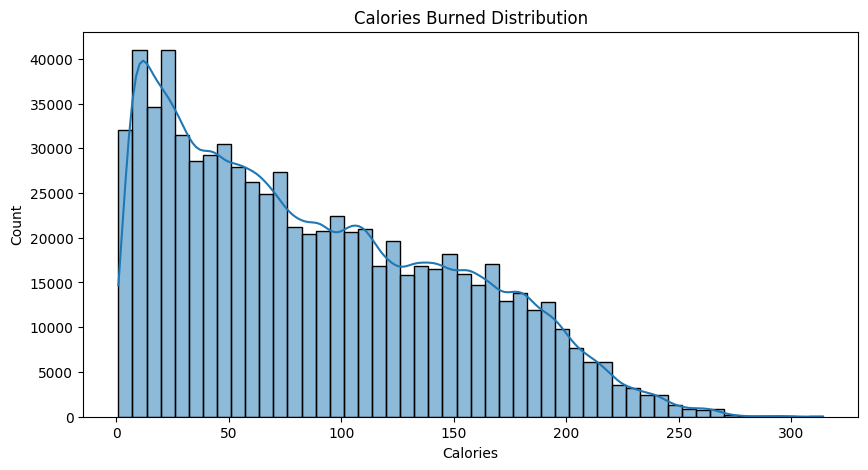

In [6]:

# EDA Visualisations
plt.figure(figsize=(10, 5))
sns.histplot(train['Calories'], bins=50, kde=True)
plt.title('Calories Burned Distribution')
plt.show()


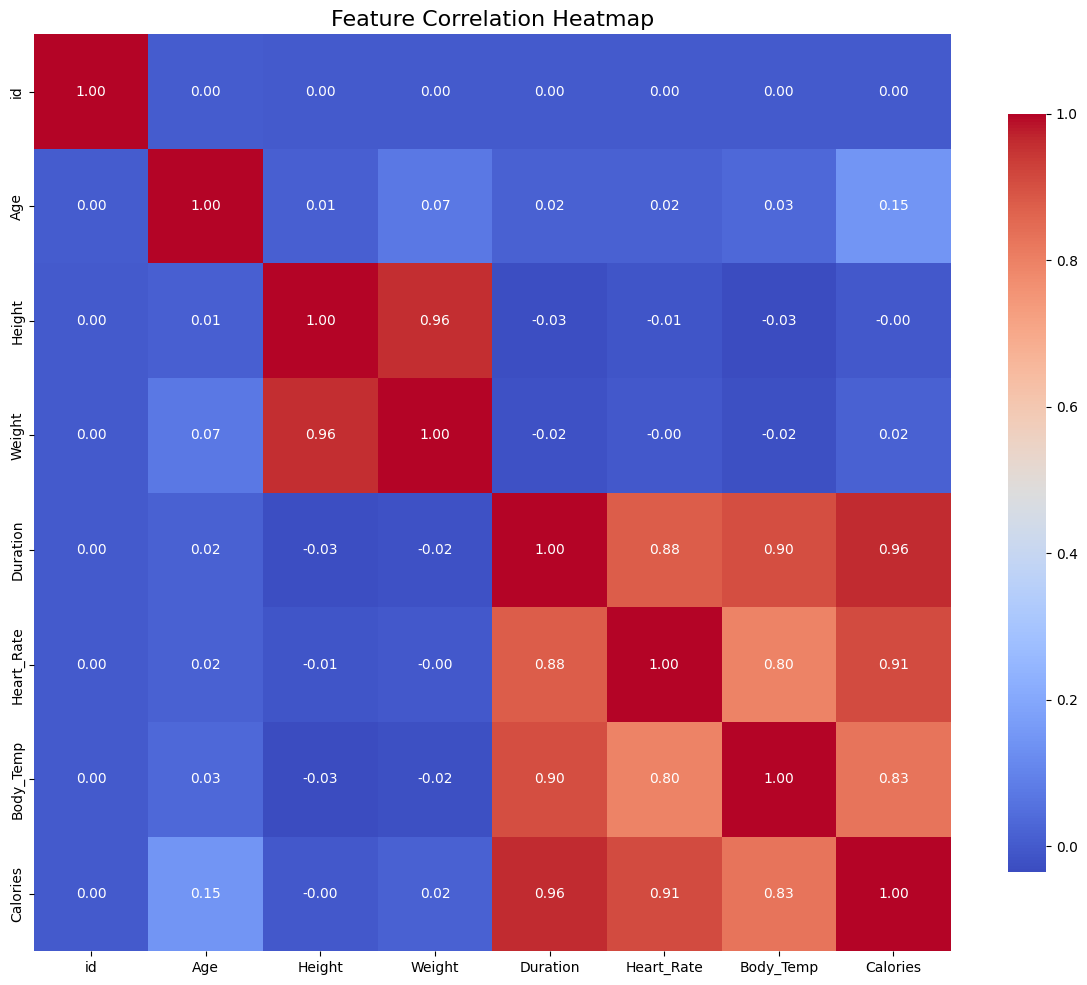

In [7]:
# Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = train.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
# Basic Cleaning
train_id = train['id']
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)


In [9]:
# Feature Engineering
train['BMI'] = train['Weight'] / ((train['Height']/100)**2)
test['BMI'] = test['Weight'] / ((test['Height']/100)**2)
train['Age*BMI'] = train['Age'] * train['BMI']
test['Age*BMI'] = test['Age'] * test['BMI']

# Check if 'Gender' column exists before attempting to use and drop it
if 'Gender' in train.columns:
    train['Gender_Code'] = train['Gender'].map({'Male': 0, 'Female': 1})
    train.drop('Gender', axis=1, inplace=True)

if 'Gender' in test.columns:
    test['Gender_Code'] = test['Gender'].map({'Male': 0, 'Female': 1})
    test.drop('Gender', axis=1, inplace=True)

In [10]:
if 'Gender' in train.columns:
    train['Gender_Code'] = train['Gender'].map({'Male': 0, 'Female': 1})
    train.drop('Gender', axis=1, inplace=True)
# Assuming 'Sex' is the actual column name based on the error, but the code uses 'Gender'.
# Let's add a check for 'Sex' as well, just in case.
elif 'Sex' in train.columns:
    train['Gender_Code'] = train['Sex'].map({'male': 0, 'female': 1}) # Mapping based on error message
    train.drop('Sex', axis=1, inplace=True)


if 'Gender' in test.columns:
    test['Gender_Code'] = test['Gender'].map({'Male': 0, 'Female': 1})
    test.drop('Gender', axis=1, inplace=True)
elif 'Sex' in test.columns:
    test['Gender_Code'] = test['Sex'].map({'male': 0, 'female': 1}) # Mapping based on error message
    test.drop('Sex', axis=1, inplace=True)

# Separate features (X) and target (y) BEFORE applying the preprocessor
X = train.drop('Calories', axis=1) # Features for training
y = train['Calories']             # Target variable for training
X_test = test.copy()              # Features for testing (no target)

# Now define and apply the preprocessor after non-numeric columns are handled
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    ('power', PowerTransformer())
])

# Fit the preprocessor only on the training features (X)
train_processed = preprocessor.fit_transform(X)

# Transform the test features (X_test) using the fitted preprocessor
test_processed = preprocessor.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.99)
train_pca = pca.fit_transform(train_processed)
test_pca = pca.transform(test_processed)

In [11]:
print(train.head())

   Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories        BMI  \
0   36   189.0    82.0      26.0       101.0       41.0     150.0  22.955684   
1   64   163.0    60.0       8.0        85.0       39.7      34.0  22.582709   
2   51   161.0    64.0       7.0        84.0       39.8      29.0  24.690405   
3   20   192.0    90.0      25.0       105.0       40.7     140.0  24.414062   
4   38   166.0    61.0      25.0       102.0       40.6     146.0  22.136740   

       Age*BMI  Gender_Code  
0   826.404636            0  
1  1445.293387            1  
2  1259.210679            1  
3   488.281250            0  
4   841.196110            1  


In [12]:
print(test.head())

   Age  Height  Weight  Duration  Heart_Rate  Body_Temp        BMI  \
0   45   177.0    81.0       7.0        87.0       39.8  25.854639   
1   26   200.0    97.0      20.0       101.0       40.5  24.250000   
2   29   188.0    85.0      16.0       102.0       40.4  24.049344   
3   39   172.0    73.0      20.0       107.0       40.6  24.675500   
4   30   173.0    67.0      16.0        94.0       40.5  22.386314   

       Age*BMI  Gender_Code  
0  1163.458776            0  
1   630.500000            0  
2   697.430964            1  
3   962.344511            1  
4   671.589428            1  


In [13]:
print(submission.head())

       id  Calories
0  750000    88.283
1  750001    88.283
2  750002    88.283
3  750003    88.283
4  750004    88.283


In [14]:
# Display the first few rows of the processed data
print("\nProcessed Train data (after imputation, scaling, power transform, and PCA):\n", train_pca[:5])
print("\nProcessed Test data (after imputation, scaling, power transform, and PCA):\n", test_pca[:5])



Processed Train data (after imputation, scaling, power transform, and PCA):
 [[ 7.03516838e-01  1.98433785e+00 -1.07540976e+00 -1.34531769e+00
  -6.73765632e-01 -7.85384899e-01]
 [-1.54978709e+00 -1.41344467e+00  2.28855318e+00 -5.66726658e-01
  -2.24468116e-01 -2.88100704e-01]
 [-1.01026317e+00 -1.50235866e+00  1.60242599e+00  6.79403104e-01
   3.64841214e-01 -4.08909501e-01]
 [ 1.07093923e+00  1.59277830e+00 -2.85325700e+00 -5.22021747e-01
  -4.00892311e-02  2.60390771e-03]
 [-2.11637591e+00  1.42938666e+00  1.69220906e-02 -6.75278324e-01
  -9.04367080e-02 -8.06095858e-02]]

Processed Test data (after imputation, scaling, power transform, and PCA):
 [[ 1.45029488 -1.36244819  0.42824386  0.60194002 -0.37495213 -0.20495552]
 [ 1.73875083  0.79705532 -2.26439469 -1.12279435  0.14098069  0.05190562]
 [ 0.00387985  0.50598477 -1.27221548 -0.81949459  1.32696003  0.41143118]
 [-0.55179561  1.42771662  0.10852519  0.1702622   0.83666772  0.4943924 ]
 [-1.7148652   0.14279136 -0.84817895 -

In [15]:
# Display the number of components chosen by PCA
print(f"\nNumber of PCA components selected: {pca.n_components_}")


Number of PCA components selected: 6


In [16]:
# Initialize lists to store validation results and final test predictions
all_val_preds = []
all_val_true = []
val_scores = []
# Use the PCA-transformed data for training and validation split
X_pca = train_pca
# Keep the original target variable y as is
y_original = y # Store original y before potential log transformation if needed

# Define KFold split
kf = KFold(n_splits=5, shuffle=True, random_state=2025) # Define kf here

final_preds = np.zeros(test_pca.shape[0]) # Initialize final_preds with the shape of the processed test data

# Cross-validation loop using the PCA-transformed data
# Use kf.split on the indices of the PCA-transformed data or the original data shape
# since the split is based on the number of samples.
# The important part is to index the PCA-transformed data (X_pca) using these indices.
for fold, (train_idx, val_idx) in enumerate(kf.split(X_pca)): # Use X_pca for splitting indices
    print(f"\nFold {fold+1}")

    # Use the PCA-transformed data (X_pca) and the original target (y_original)
    # Index them using the indices from the kf.split(X_pca)
    X_train, X_val = X_pca[train_idx], X_pca[val_idx]
    y_train, y_val = y_original.iloc[train_idx], y_original.iloc[val_idx] # Use y_original for target split, iloc should work as y is a Series

    models = [
        ('lgb', lgb.LGBMRegressor(n_estimators=1500, learning_rate=0.008,
                                  num_leaves=60, colsample_bytree=0.85,
                                  subsample=0.9, random_state=2025)),

        ('xgb', xgb.XGBRegressor(n_estimators=1500, learning_rate=0.008,
                                 max_depth=6, subsample=0.85, colsample_bytree=0.85,
                                 objective='reg:squarederror', random_state=2025)),

        ('cat', cb.CatBoostRegressor(iterations=1500, learning_rate=0.008,
                                     depth=6, verbose=0, random_seed=2025)),

        ('mlp', MLPRegressor(hidden_layer_sizes=(128,64), max_iter=1000, learning_rate_init=0.001, random_state=2025)),

        ('ridge', Ridge(alpha=1.0)),

        ('lasso', Lasso(alpha=0.001))
    ]

    ensemble = StackingRegressor(
        estimators=models,
        final_estimator=lgb.LGBMRegressor(n_estimators=500, learning_rate=0.03),
        passthrough=True
    )



Fold 1

Fold 2

Fold 3

Fold 4

Fold 5


In [17]:
# Training
ensemble.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 6
[LightGBM] [Info] Start training from score 88.309295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 6
[LightGBM] [Info] Start training from score 88.332629
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 6
[LightGBM] [Info] Start t

StackingRegressor(estimators=[('lgb',
                               LGBMRegressor(colsample_bytree=0.85,
                                             learning_rate=0.008,
                                             n_estimators=1500, num_leaves=60,
                                             random_state=2025,
                                             subsample=0.9)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.85, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=Fa...
                                            n_estimators=1500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=2025, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7d29c45b5f10>),
                              ('mlp',
                               MLPRegressor(hidden_layer_sizes=(128, 64),
                                            max_iter=1000, random_state=2025)),
                              ('ridge', Ridge()),
                              ('lasso', Lasso(alpha=0.001))],
                  final_estimator=LGBMRegressor(learning_rate=0.03,
                                                n_estimators=500),
                  passthrough=True)

In [18]:
# Validation
val_preds = ensemble.predict(X_val)
all_val_preds.extend(val_preds)
all_val_true.extend(y_val)


In [19]:
# Evaluation on validation set for this fold
rmse_val = mean_squared_error(y_val, val_preds, squared=False)
mae_val = mean_absolute_error(y_val, val_preds)
r2_val = r2_score(y_val, val_preds)

In [20]:
print(f"Fold {fold+1} - Validation RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}")
val_scores.append({'Fold': fold+1, 'RMSE': rmse_val, 'MAE': mae_val, 'R2': r2_val})

Fold 5 - Validation RMSE: 4.4959, MAE: 2.9760, R2: 0.9948


In [21]:
# Testing (Predict on the test set for this fold)
fold_test_preds = ensemble.predict(test_pca) # Predict on the processed test data
final_preds += fold_test_preds / kf.n_splits # Accumulate predictions and average later

In [22]:
# --- Evaluation on all validation predictions ---
overall_rmse = mean_squared_error(all_val_true, all_val_preds, squared=False)
overall_mae = mean_absolute_error(all_val_true, all_val_preds)
overall_r2 = r2_score(all_val_true, all_val_preds)

print("\n--- Overall Validation Results ---")


--- Overall Validation Results ---


In [23]:
print(f"Overall RMSE: {overall_rmse:.4f}")

Overall RMSE: 4.4959


In [24]:
print(f"Overall MAE: {overall_mae:.4f}")

Overall MAE: 2.9760


In [25]:
print(f"Overall R2: {overall_r2:.4f}")


Overall R2: 0.9948


In [26]:
# Display validation scores per fold
val_scores_df = pd.DataFrame(val_scores)
print("\nValidation Scores per Fold:")
print(val_scores_df)



Validation Scores per Fold:
   Fold      RMSE       MAE        R2
0     5  4.495904  2.975995  0.994826


In [27]:
print("\nFirst 10 final test predictions (averaged across folds):")
print(final_preds[:10])


First 10 final test predictions (averaged across folds):
[ 5.80286653 21.15232903 18.10055191 26.07093158 14.67366795  3.85391674
  9.60634006  1.20129156  2.10574782 39.85537394]


In [28]:
# Create submission DataFrame
submission['Calories'] = final_preds
submission.to_csv('submission.csv', index=False)

In [29]:
print("\nSubmission file created successfully: submission.csv")
print("\nFirst 5 rows of the submission file:")
print(submission.head())


Submission file created successfully: submission.csv

First 5 rows of the submission file:
       id   Calories
0  750000   5.802867
1  750001  21.152329
2  750002  18.100552
3  750003  26.070932
4  750004  14.673668
